# Revisão do artigo “Model-independent quantum phases classifier”

In [4]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.patches as mpatches

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": [
            "STIX Two Text",
        ],
        "font.sans-serif": ["NewComputerModernSans", "San Francisco Display"],
        "axes.labelsize": 20,
        "font.size": 20,
        "legend.fontsize": 25,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "figure.titlesize": 22,
        "svg.fonttype": "none",
    }
)

In [5]:
PHASES = ("Haldane", "Trimer", "Ferro", "Dimer", "LD", "XY1", "Neel", "XY2")
COLORS = (
    "#00A087",  # Teal Green
    "#3B75AF",  # Royal Blue
    "#F37735",  # Vibrant Orange
    "#FFC425",  # Gold
    "#E83E8C",  # Magenta
    "#7B52A1",  # Royal Purple
    "#0B2545",  # Oxford Blue
    "#999999",  # Medium Gray
)

H_KEYS = ("H1", "H2", "H3")
SUBGRAPHS = ("(a)", "(b)", "(c)")
PHASE_COLORS = dict(zip(PHASES, COLORS))
KEYS_SUBGRAPHS = dict(zip(H_KEYS, SUBGRAPHS))

phase_trans_H1 = pd.read_csv("data/theoretical/XXZ.csv", header=None).values
phase_trans_H2 = pd.read_csv(
    "data/theoretical/bond-alternating.csv", header=None
).values
PI = np.pi
phase_trans_H3 = np.array([[0.25, -1], [0.5, -1], [1.25, -1], [1.75, -1]])

PHASE_TRANSITIONS = {"H1": phase_trans_H1, "H2": phase_trans_H2, "H3": phase_trans_H3}

N = 12

## Assigning Labels

The bounderies of each phase are taken from the Reference [4]. You can find them online in https://github.com/Fmahlow/FasesQuanticasML

In [6]:
def assign_labels(corr_dfs: dict[str, pd.DataFrame]):
    ######################## H3 LABELING ########################

    H1_labels = []
    for i in range(0, len(corr_dfs["H1"])):
        x = corr_dfs["H1"].values[i, 0]
        y = corr_dfs["H1"].values[i, 1]

        # Ferro/LD phases
        if x < -1.8375250:
            if y < (-0.1009) * (x**2) - 1.6701 * x - 1.329:
                H1_labels.append(2)
            else:
                H1_labels.append(4)

        # Ferro/XY phases
        elif x >= -1.837525 and x < -0.278:
            if y > -0.0741 * x**3 - 0.3014 * x**2 - 0.872 * x + 0.3499:
                H1_labels.append(4)
            elif (
                y
                < -5.1127 * x**5
                - 27.865 * x**4
                - 57.426 * x**3
                - 55.858 * x**2
                - 27.638 * x
                - 6.4824
            ):
                H1_labels.append(2)
            else:
                H1_labels.append(5)

        elif x >= -0.278 and x < 0:
            if y > -0.0741 * x**3 - 0.3014 * x**2 - 0.872 * x + 0.3499:
                H1_labels.append(4)
            elif (
                y
                < -5.1127 * x**5
                - 27.865 * x**4
                - 57.426 * x**3
                - 55.858 * x**2
                - 27.638 * x
                - 6.4824
            ):
                H1_labels.append(2)
            elif y < 4.595 * x**2 + 1.393 * x - 2.007:
                H1_labels.append(7)
            else:
                H1_labels.append(5)

        # LD/Haldane phases
        elif x >= 0 and x < 3.28405:
            if y > 0.0807 * x**2 + 0.5418 * x + 0.3465:
                H1_labels.append(4)
            elif y > -0.0462 * x**3 + 0.154 * x**2 + 1.5213 * x - 2.0196:
                H1_labels.append(0)
            else:
                H1_labels.append(6)

        # LD/Neel phases
        elif x >= 3.28405 and x <= 4:
            if y > 1.0906 * x - 0.583:
                H1_labels.append(4)
            else:
                H1_labels.append(6)

    corr_dfs["H1"]["labels"] = [PHASES[i] for i in H1_labels]

    ######################## H2 LABELING ########################

    # labels Bond correlations
    H2_labels = []
    for i in range(0, len(corr_dfs["H2"])):
        x = corr_dfs["H2"].values[i, 0]
        y = corr_dfs["H2"].values[i, 1]

        # Ferro phases
        if x < -1:
            H2_labels.append(2)

        # XY/Dimer phases
        elif x >= -1 and x < 0:
            if y > 0.1435 * x**2 - 0.6447 * x + 0.2197:
                H2_labels.append(3)
            else:
                H2_labels.append(5)

        # HALDANE/DIMER
        elif x >= 0 and x < 1:
            if y > 0.0043 * x**3 - 0.0384 * x**2 + 0.0631 * x + 0.2317:
                H2_labels.append(3)
            else:
                H2_labels.append(0)

        # Haldane/Neel phases
        elif x >= 1.0 and x <= 1.2:
            if y > -0.0872 * x**2 + 0.6067 * x - 0.2264:
                H2_labels.append(3)
            elif y > -247.1 * x**3 + 826.12 * x**2 - 921.85 * x + 343.48:
                H2_labels.append(6)
            else:
                H2_labels.append(0)

        # Neel/Dimer phases
        elif x > 1.2 and x <= 2.5:
            if y > -0.0872 * x**2 + 0.6067 * x - 0.2264:
                H2_labels.append(3)
            else:
                H2_labels.append(6)

    corr_dfs["H2"]["labels"] = [PHASES[i] for i in H2_labels]

    ######################## H3 LABELING ########################
    # Labels bilinear
    H3_labels = []

    for i in range(0, len(corr_dfs["H3"])):
        # Haldane phases
        if (
            corr_dfs["H3"].values[i, 0] <= 0.25
            and corr_dfs["H3"].values[i, 0] >= 0
            or corr_dfs["H3"].values[i, 0] > 1.75
            and corr_dfs["H3"].values[i, 0] <= 2
        ):
            H3_labels.append(0)
        # Trimer phases
        elif corr_dfs["H3"].values[i, 0] > 0.25 and corr_dfs["H3"].values[i, 0] <= 0.5:
            H3_labels.append(1)
        # Ferro phases
        elif corr_dfs["H3"].values[i, 0] > 0.5 and corr_dfs["H3"].values[i, 0] <= 1.25:
            H3_labels.append(2)
        # Dimer phases
        else:
            H3_labels.append(3)

    corr_dfs["H3"]["labels"] = [PHASES[i] for i in H3_labels]

In [7]:
def read_correlations(N: int) -> dict[str, pd.DataFrame]:
    corr_dfs = {}
    pred_dfs = {}
    for i in range(1, 4):
        corr_dfs[f"H{i}"] = pd.read_csv(f"data/H{i}/N={N}.csv")
        pred_dfs[f"H{i}"] = pd.DataFrame(corr_dfs[f"H{i}"].values[:, :2])
        pred_dfs[f"H{i}"]["knn"] = np.empty(corr_dfs[f"H{i}"].shape[0])

    assign_labels(corr_dfs)

    # Normalization, if done, must happen AFTER this point

    return corr_dfs, pred_dfs


corr_dfs, pred_dfs = read_correlations(N)

# I also want a dataframe with all the correlations
map_H1 = {"Jz": "param1", " D": "param2"}
map_H2 = {"Delta": "param1", " delta": "param2"}
map_H3 = {"theta": "param1", " -1": "param2"}

corr_dfs["all"] = pd.concat(
    [
        corr_dfs["H1"].rename(columns=map_H1),
        corr_dfs["H2"].rename(columns=map_H2),
        corr_dfs["H3"].rename(columns=map_H3),
    ]
).reset_index(drop=True)

In [8]:
def get_Xy(df: pd.DataFrame):
    return (df.values[:, 2:-1], df.values[:, -1])

## Data exploration

In [9]:
df = corr_dfs["H3"]
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [theta,  -1,  S1S1x,  S1S1y,  S1S1z,  S1S2x,  S1S2y,  S1S2z,  S1S3x,  S1S3y,  S1S3z,  S1S4x,  S1S4y,  S1S4z,  S1S5x,  S1S5y,  S1S5z,  S1S6x,  S1S6y,  S1S6z,  S1S7x,  S1S7y,  S1S7z,  prodSix,  prodSiy,  prodSiz, labels]
Index: []

[0 rows x 27 columns]

## Phase distribution

In ML, it is important to have a balanced dataset. We explore below the distribution of phases in our data.

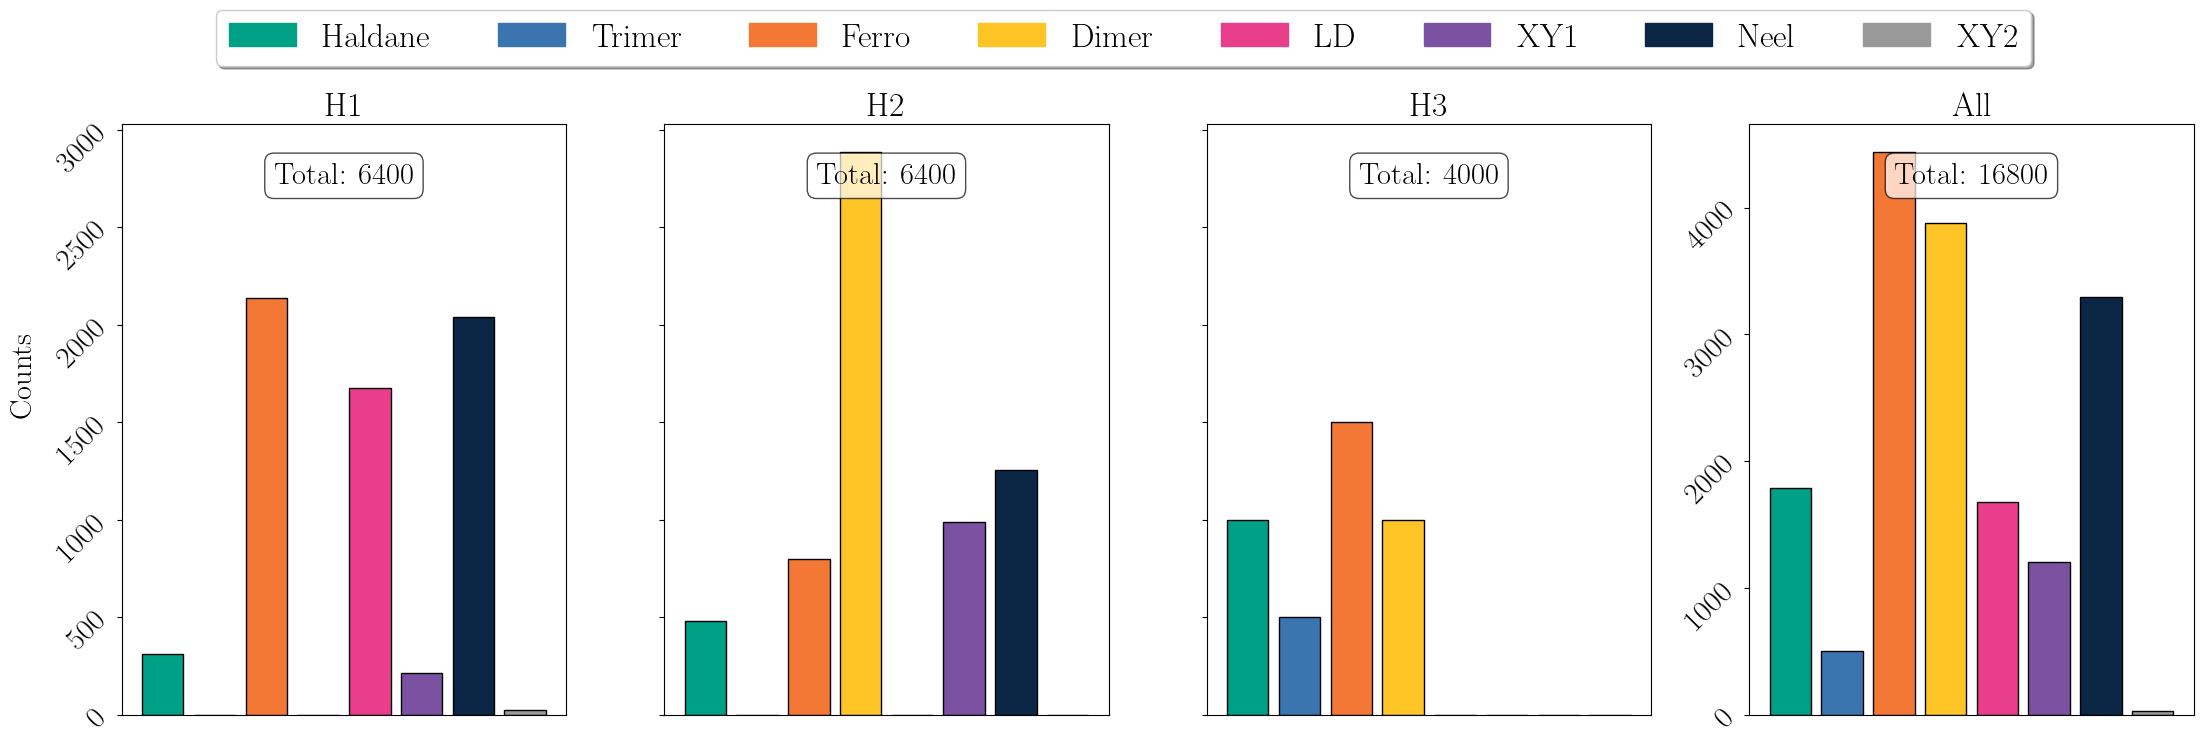

In [10]:
def plot_phase_distribution(corr_dfs: dict[str, pd.DataFrame]):
    import matplotlib.pyplot as plt

    legend_patches = []
    for phase in PHASES:
        patch = mpatches.Patch(color=PHASE_COLORS.get(phase, "gray"), label=f"{phase}")
        legend_patches.append(patch)

    fig, axs = plt.subplots(1, 4, figsize=(22, 7))
    axs[1].sharey(axs[0])
    axs[1].tick_params("y", labelleft=False)
    axs[2].sharey(axs[0])
    axs[2].tick_params("y", labelleft=False)
    axs[0].tick_params(axis="y", labelrotation=45)
    axs[3].tick_params(axis="y", labelrotation=45)
    fig.text(-0, 0.5, "Counts", ha="center", rotation=90, fontsize=22)
    fig.legend(
        handles=legend_patches,
        loc="upper center",  # Position at the top
        ncol=len(PHASES),  # Arrange horizontally
        bbox_to_anchor=(0.5, 1.1),  # Place it just above the subplots
        fancybox=True,
        shadow=True,
        fontsize="large",
    )

    for i, (key, df) in enumerate(corr_dfs.items()):
        _phases, counts = np.unique(df["labels"], return_counts=True)

        # Create a dictionary for quick lookup
        counts_dict = dict(zip(_phases, counts))

        full_counts = [counts_dict.get(p, 0) for p in PHASES]
        colors = [PHASE_COLORS[phase] for phase in PHASES]

        axs[i].bar(PHASES, full_counts, color=colors, edgecolor="black", width=0.8)

        axs[i].set_title(f"{key.capitalize()}")
        axs[i].annotate(
            f"Total: {len(df)}",
            xy=(0.5, 0.9),
            xycoords="axes fraction",
            ha="center",
            fontsize=22,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        )
        axs[i].set_xticks([])

    # fig.suptitle(r"$\textbf{Phase Distribution}$")
    fig.tight_layout()
    fig.savefig("images/phase_distribution.png")


plot_phase_distribution(corr_dfs)

<class 'matplotlib.axes._axes.Axes'>


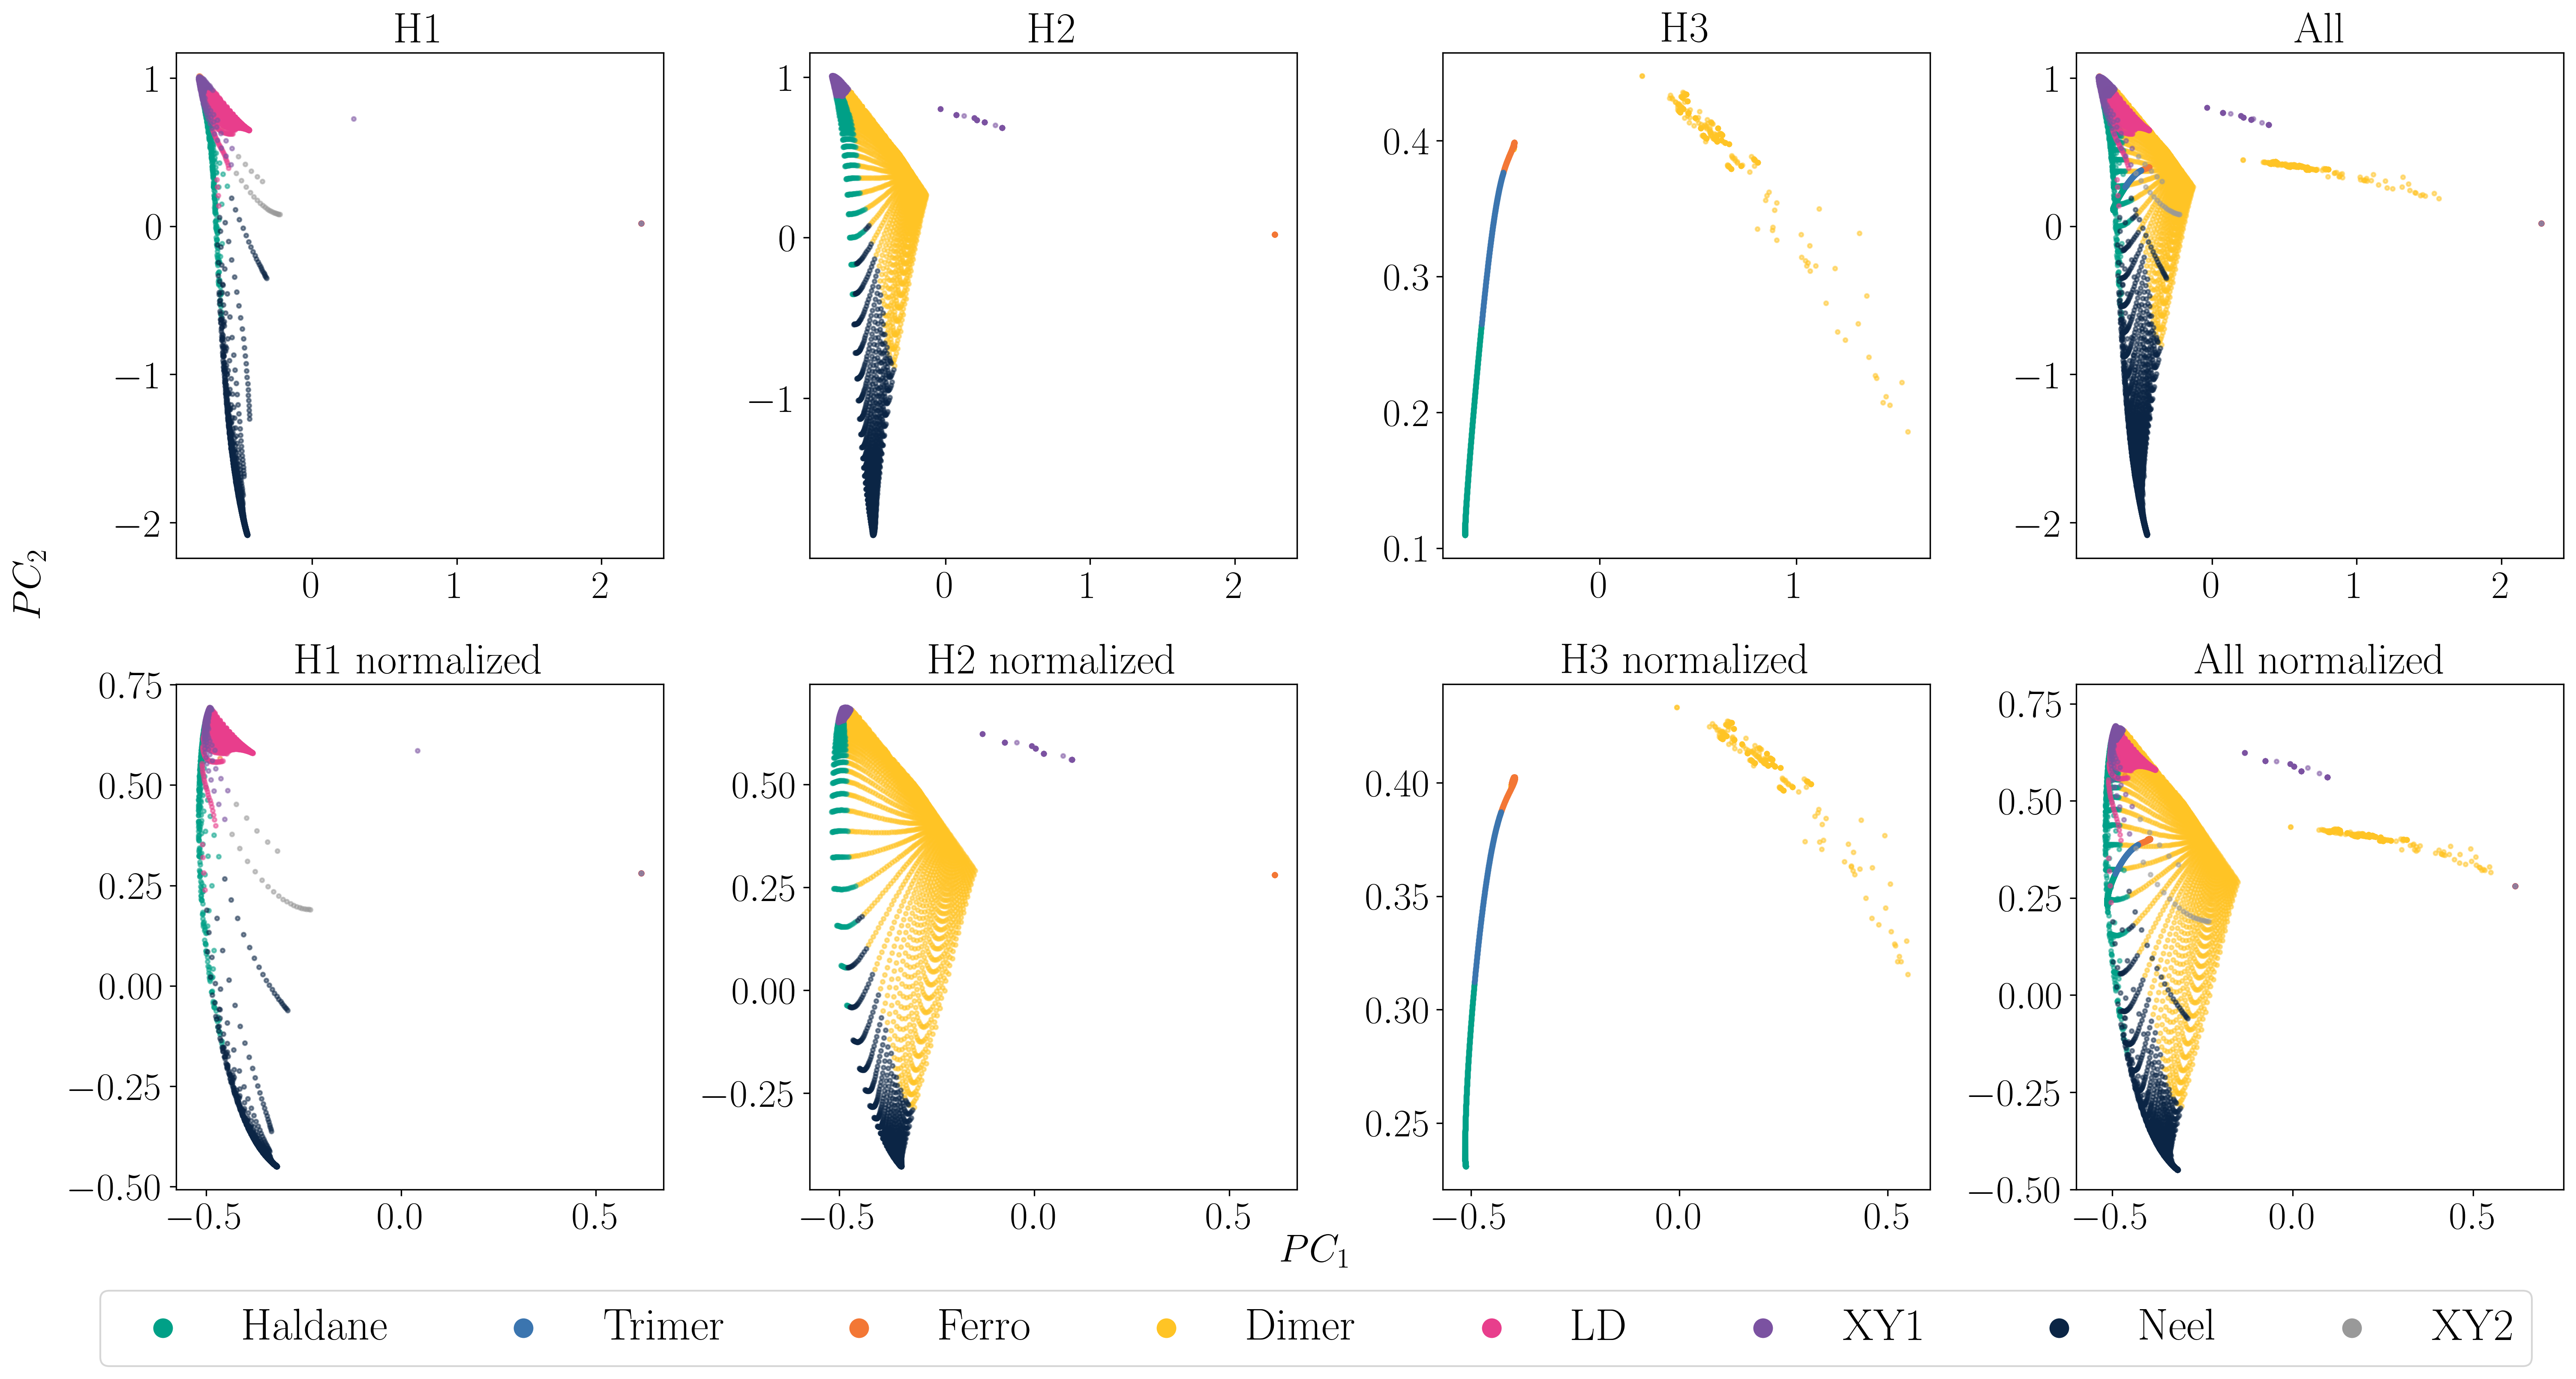

In [ ]:
PCA_keys = H_KEYS + tuple(["all"])

_fig, _axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 11), dpi=300)
handles, labels = [], []

def plot_PCA(
    corr_dfs: dict[str, pd.DataFrame],
    key: str,
    ax: Axes,
    _normalize: bool = True,
):
    steps = []  # pipeline steps

    X, y = get_Xy(corr_dfs[key])

    pca = PCA(n_components=2)
    pca.fit(get_Xy(corr_dfs["all"])[0])

    if _normalize:
        steps.append(("normalizer", Normalizer()))
    steps.append(("pca", pca))
    pipe = Pipeline(steps)

    X = pipe.transform(X)

    norm_str = " normalized" if _normalize else ""

    if key == "all" and _normalize:
        ax.set_xlim([-0.6, 0.75])
        ax.set_ylim([-0.5, 0.8])

    ax.set_title(f"{key.capitalize()}{norm_str}")

    classes = np.unique(y)
    for c in classes:
        nodes = np.where(y == c)
        ax.scatter(
            X[nodes, 0],
            X[nodes, 1],
            color=PHASE_COLORS[c],
            label=c,
            alpha=0.5,
            s=5,
        )

    return None


for i in range(8):
    _normalize = i // 4 != 0
    plot_PCA(corr_dfs, PCA_keys[i % 4], _axs.flatten()[i], _normalize=_normalize)

for i in range(len(PHASES)):
    handles.append(
        plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o", s=100)
    )

_fig.legend(
    handles,
    list(PHASES),
    loc="lower center",
    ncol=len(PHASES),
    bbox_to_anchor=(0.5, -0.05),
)

_fig.text(-0, 0.5, r"$PC_2$", ha="center", rotation=90, fontsize=22)
_fig.text(0.5, 0.04, r"$PC_1$", ha="center", fontsize=22)


plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))  # Adjust rect to make space for suptitle


_fig.savefig(f"images/PCA_corr_N{N}.png")


## Machine Learning

### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier


def KNN_classify(
    test_key: str,
    ignored_phases: list[str] = [],
    corr_dfs: dict[str, pd.DataFrame] = corr_dfs,
    pred_dfs: dict[str, pd.DataFrame] = pred_dfs,
) -> str | dict:
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    knn = KNeighborsClassifier()

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            # ("pca", PCA(n_components=8)),
            ("knn", knn),
        )
    )

    pipe.fit(X, y)  # type: ignore
    X_pred = get_Xy(corr_dfs[test_key])[0]

    pred_dfs[test_key]["knn"] = pipe.predict(X_pred)

    # This is ugly please adjust it later to make it less redundant
    y_test_pred = pipe.predict(X_test)
    print(f"{test_key} prediction score: {pipe.score(X_test, y_test)}")
    # print(classification_report(y_test, y_test_pred))


KNN_classify("H3", ["Trimer"])
KNN_classify("H2")
KNN_classify("H1", ["LD", "XY1"])

H3 prediction score: 0.5137142857142857
H2 prediction score: 0.72515625
H1 prediction score: 0.9838137472283813


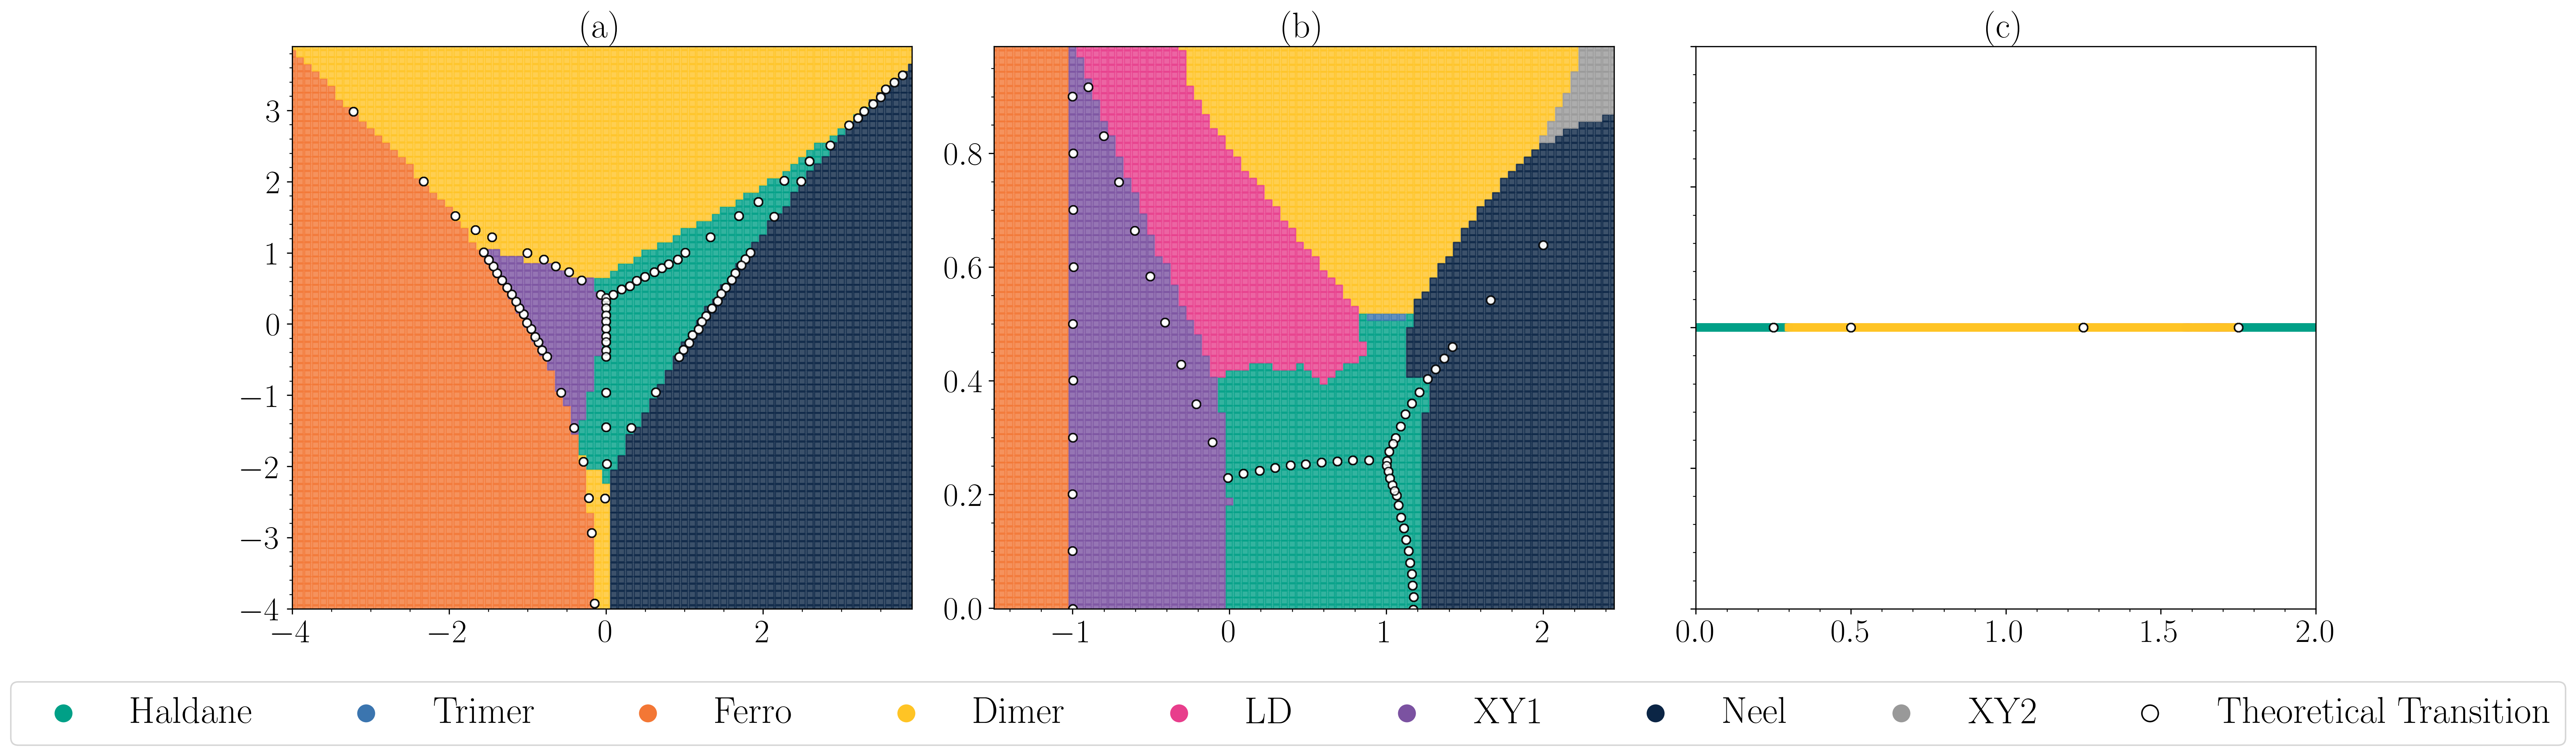

In [13]:
handles, labels = [], []


def plot_graphs(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
    ax.set_title(f"{KEYS_SUBGRAPHS[key]}")
    df = pred_dfs[key]
    for phase in PHASES:
        phase_data = df[df["knn"] == phase].values

        ax.scatter(
            phase_data[:, 0],
            phase_data[:, 1],
            marker="s",
            label=phase,
            color=PHASE_COLORS[phase],
            alpha=0.8,
            s=18,
        )
        ax.scatter(
            PHASE_TRANSITIONS[key][:, 0],
            PHASE_TRANSITIONS[key][:, 1],
            marker="o",
            label="Theoretical Transition",
            color="white",
            alpha=0.8,
            s=30,
            edgecolor="black",
        )
    ax.tick_params(
        axis="both",
        which="major",
    )
    ax.minorticks_on()

    # Collect all x and y values for setting axis limits
    all_x, all_y = [], []
    all_x.extend(df.values[:, 0])
    all_y.extend(df.values[:, 1])
    ax.tick_params(
        axis="both",
        which="major",
    )
    # Set tight axis limits
    if len(all_x) > 0 and len(all_y) > 0:
        ax.set_xlim(min(all_x) - 0.001, max(all_x) + 0.001)
        ax.set_ylim(min(all_y) - 0.001, max(all_y) + 0.001)
    if key == "H3":
        ax.set_xlim(0, 2)
        ax.set_ylim(-1.1, -0.9)
        ax.set_yticklabels([])


_fig, _axs = plt.subplots(figsize=(20, 7), ncols=3, nrows=1, dpi=300)
# _fig.suptitle(r"""$\textbf{Prediction of Phases}$
#               $\textbf{Using KNN}$""")
for i in range(len(PHASES)):
    handles.append(
        plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o", s=120)
    )
handles.append(plt.scatter([1], [1], c="white", edgecolor="black", marker="o", s=120))

_fig.legend(
    handles,
    list(PHASES) + ["Theoretical Transition"],
    loc="lower center",
    ncol=len(PHASES) + 1,
    bbox_to_anchor=(0.5, -0.04),
)

for i in range(3):
    plot_graphs(pred_dfs, H_KEYS[i], _axs.flatten()[i])

plt.tight_layout(rect=(0.0, 0.07, 1.0, 1))  # Adjust rect to make space for suptitle

_fig.savefig(f"images/knn_prediction_N{N}.png")

### Random Forest

In [14]:
def RF_classify(
    test_key: str,
    ignored_phases: list[str] = [],
    corr_dfs: dict[str, pd.DataFrame] = corr_dfs,
    pred_dfs: dict[str, pd.DataFrame] = pred_dfs,
):
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    rf = RandomForestClassifier(
        n_estimators=15,
        random_state=5012,
        min_samples_split=100,
        class_weight="balanced",
    )

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            ("rf", rf),
        )
    )

    pipe.fit(X, y)  # type: ignore

    X_pred = get_Xy(corr_dfs[test_key])[0]
    pred_dfs[test_key]["rf_confidence"] = np.amax(pipe.predict_proba(X_pred), axis=1)
    pred_dfs[test_key]["rf"] = pipe.predict(X_pred)
    print(f"{test_key} prediction score: {pipe.fit(X, y).score(X_test, y_test)}")  # type: ignore


RF_classify("H3", ["Trimer"])
RF_classify("H2")
RF_classify("H1", ["LD", "XY1"])

H3 prediction score: 0.4797142857142857
H2 prediction score: 0.60578125
H1 prediction score: 0.982039911308204


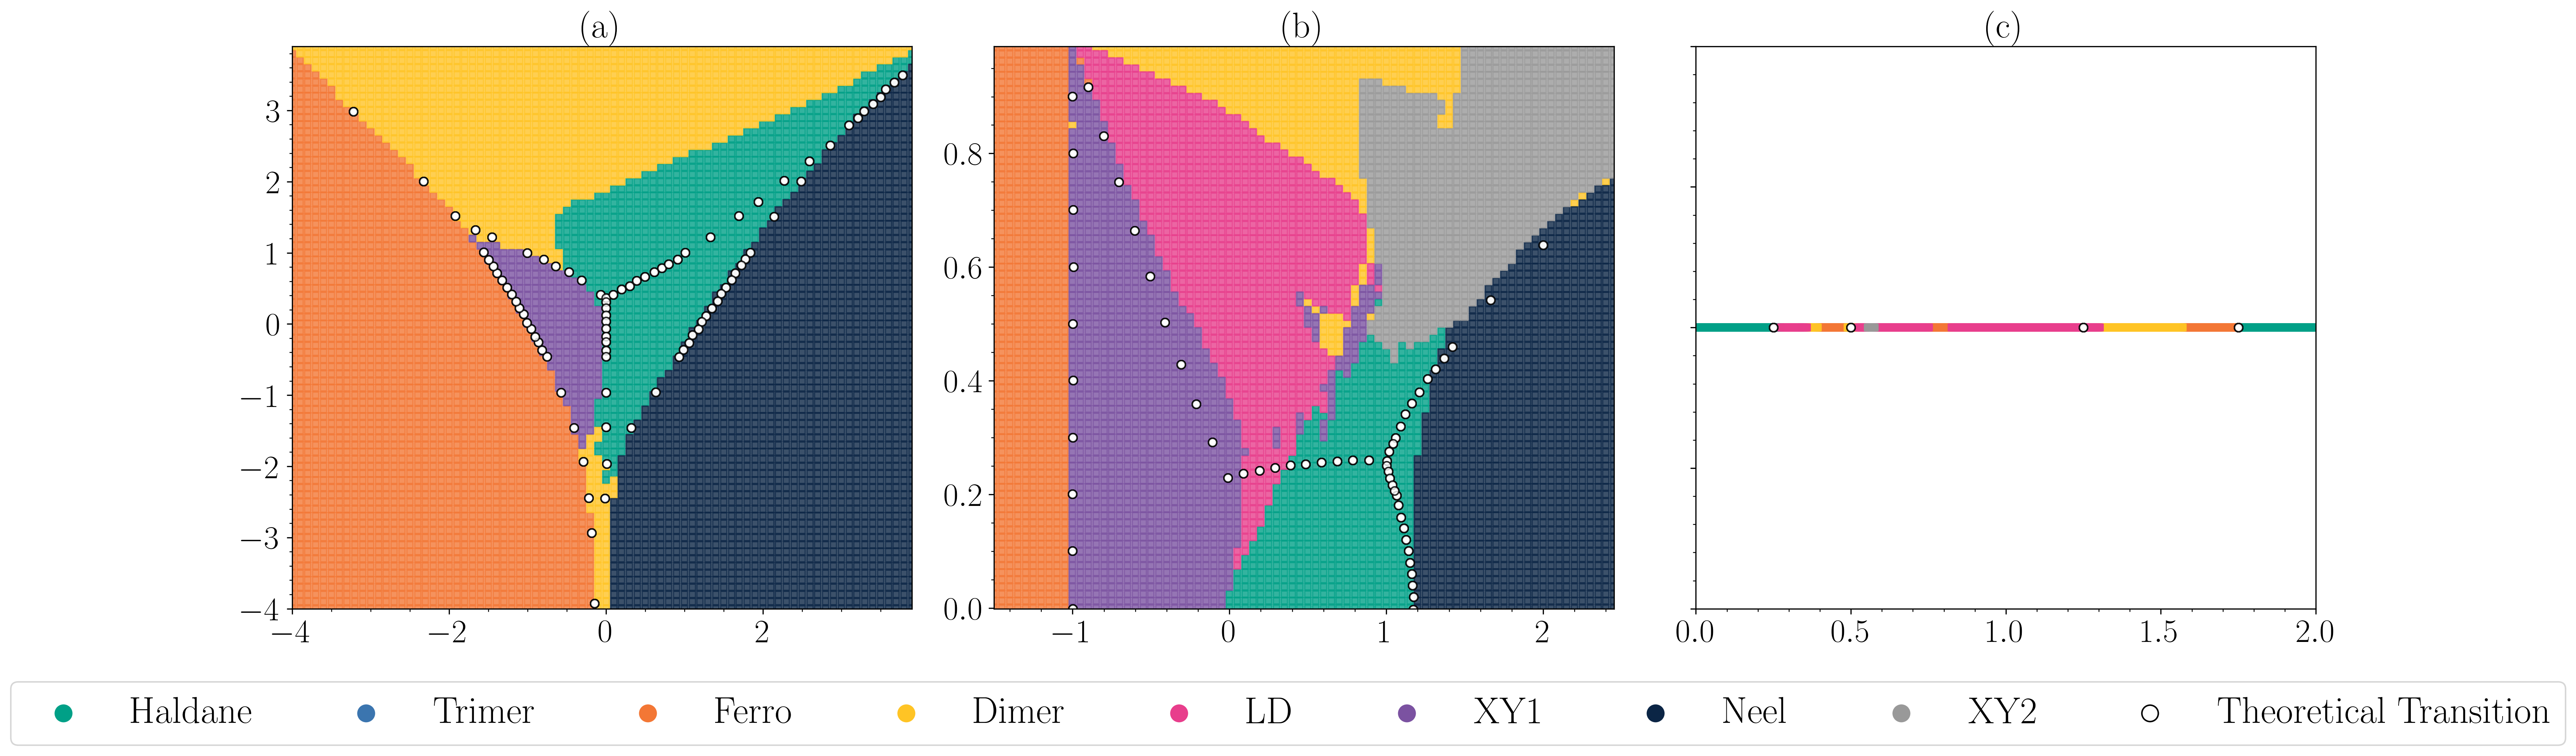

In [15]:
handles, labels = [], []


def plot_graphs_rf(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
    ax.set_title(f"{KEYS_SUBGRAPHS[key]}")
    df = pred_dfs[key]
    for phase in PHASES:
        phase_data = df[df["rf"] == phase].values
        ax.scatter(
            phase_data[:, 0],
            phase_data[:, 1],
            marker="s",
            label=phase,
            color=PHASE_COLORS[phase],
            alpha=0.8,
            s=18,
        )
        ax.scatter(
            PHASE_TRANSITIONS[key][:, 0],
            PHASE_TRANSITIONS[key][:, 1],
            marker="o",
            label="Theoretical",
            color="white",
            edgecolors="black",
            alpha=0.8,
            s=30,
        )
    ax.tick_params(
        axis="both",
        which="major",
    )
    ax.minorticks_on()

    # Collect all x and y values for setting axis limits
    all_x, all_y = [], []
    all_x.extend(df.values[:, 0])
    all_y.extend(df.values[:, 1])
    ax.tick_params(
        axis="both",
        which="major",
    )
    # Set tight axis limits
    if len(all_x) > 0 and len(all_y) > 0:
        ax.set_xlim(min(all_x) - 0.001, max(all_x) + 0.001)
        ax.set_ylim(min(all_y) - 0.001, max(all_y) + 0.001)
    if key == "H3":
        ax.set_xlim(0, 2)
        ax.set_ylim(-1.1, -0.9)
        ax.set_yticklabels([])


_fig, _axs = plt.subplots(figsize=(20, 7), ncols=3, nrows=1, dpi=300)
# _fig.suptitle(r"""$\textbf{Prediction of Phases}$
#               $\textbf{Using RF}$""")
for i in range(len(PHASES)):
    handles.append(
        plt.scatter([1], [1], c=COLORS[i], label=PHASES[i], marker="o", s=120)
    )
handles.append(plt.scatter([1], [1], c="white", edgecolor="black", marker="o", s=120))

_fig.legend(
    handles,
    list(PHASES) + ["Theoretical Transition"],
    loc="lower center",
    ncol=len(PHASES) + 1,
    bbox_to_anchor=(0.5, -0.04),
)

for i in range(3):
    plot_graphs_rf(pred_dfs, H_KEYS[i], _axs.flatten()[i])

plt.tight_layout(rect=(0.0, 0.07, 1.0, 1))  # Adjust rect to make space for suptitle

_fig.savefig(f"images/rf_prediction_N{N}.png")

/tmp/ipykernel_120860/615294320.py:60: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(np.min(y), np.max(y))


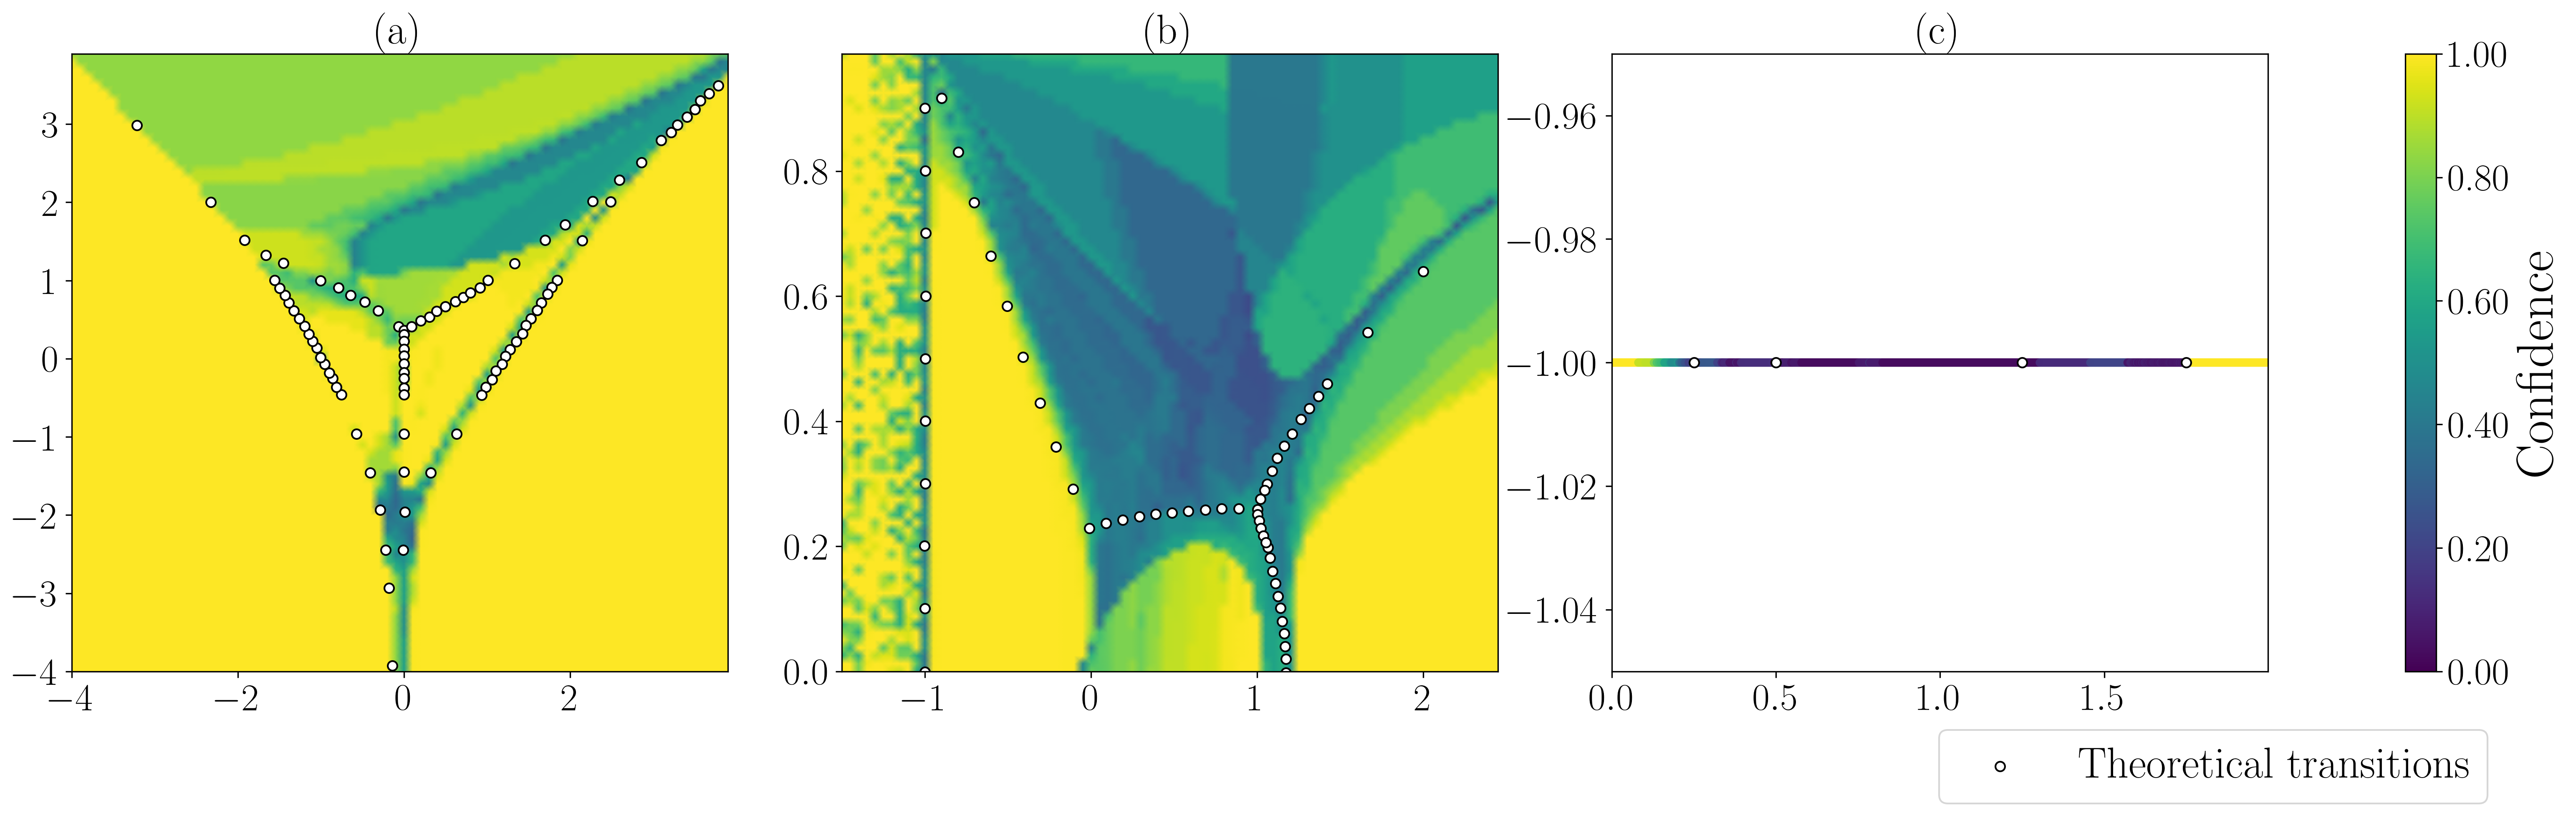

In [16]:
handles, labels = [], []

# def plot_graphs_rf_confidence(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
#     ax.set_title(f"{key}")
#     df = pred_dfs[key]
#     x, y = np.unique(df.values[:,0]), np.unique(df.values[:,1])
#     x, y = x.astype(float), y.astype(float)
#     conf = df["rf_confidence"].astype(float).values
#     conf_2d = conf.reshape(len(x), len(y))
#     X, Y = np.meshgrid(x,y)
#     ax.pcolormesh(
#         X,Y,conf_2d.T, shading='auto', vmin=0, vmax=1
#     )

_fig, _axs = plt.subplots(figsize=(23, 7), ncols=3, nrows=1, dpi=300)
# _fig.suptitle(r"""$\textbf{Confidence of prediction}$
#               $\textbf{of the RF model}$""")

# Store the mappable returned by pcolormesh for colorbar
mappables = []
for i in range(3):
    ax = _axs.flatten()[i]
    key = H_KEYS[i]
    df = pred_dfs[key]
    label = ""
    if i == 2:
        label = "Theoretical transitions"
        x, y = df.values[:, 0], df.values[:, 1]
        x, y = x.astype(float), y.astype(float)
        conf = df["rf_confidence"].astype(float).values
        ax.scatter(
            x,
            y,
            c=conf,
            cmap="viridis",
            alpha=0.8,
            s=14,
        )
    else:
        x, y = np.unique(df.values[:, 0]), np.unique(df.values[:, 1])
        x, y = x.astype(float), y.astype(float)
        conf = df["rf_confidence"].astype(float).values
        conf_2d = conf.reshape(len(x), len(y))
        X, Y = np.meshgrid(x, y)
        mappable = ax.pcolormesh(
            X, Y, conf_2d.T, shading="gouraud", cmap="viridis", vmin=0, vmax=1
        )
        mappables.append(mappable)
    ax.scatter(
        PHASE_TRANSITIONS[key][:, 0],
        PHASE_TRANSITIONS[key][:, 1],
        marker="o",
        edgecolor="black",
        label=label,
        color="white",
        alpha=1,
        s=30,
    )
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

    ax.set_title(f"{SUBGRAPHS[i]}")


plt.tight_layout(rect=(0.0, 0.07, 1.0, 0.96))  # Adjust rect to make space for suptitle

# Add colorbar using the first mappable
cbar = _fig.colorbar(mappables[0], ax=_axs, format="%.2f")
cbar.set_label("Confidence", fontsize=30)
cbar = _fig.colorbar
_fig.legend(
    loc="lower right",
    bbox_to_anchor=(0.88, -0.01),
)
_fig.savefig(f"images/rf_confidence_N{N}.png")

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression


def logistical_classify(
    corr_dfs: dict[str, pd.DataFrame],
    test_key: str,
    ignored_phases: list[str] = [],
):
    train_keys = list(corr_dfs.keys())
    train_keys.remove(test_key)
    train_keys.remove("all")

    # Gets used in the KNN
    X = None
    y = None

    for key in train_keys:
        X_key, y_key = get_Xy(corr_dfs[key])

        if X is None:
            X = X_key
        else:
            X = np.vstack((X, X_key))
        if y is None:
            y = y_key
        else:
            y = np.hstack((y, y_key))

    # Gets X_prev and Y prev
    test_df = corr_dfs[test_key][~corr_dfs[test_key]["labels"].isin(ignored_phases)]
    X_test, y_test = get_Xy(test_df)

    clf = LogisticRegression(max_iter=1000)

    pipe = Pipeline(
        (
            ("normalizer", Normalizer()),
            ("clf", clf),
        )
    )

    pipe.fit(X, y)  # type: ignore

    X_pred = get_Xy(corr_dfs[test_key])[0]
    pred_dfs[test_key]["lr"] = pipe.predict(X_pred)
    pred_dfs[test_key]["lr_confidence"] = pipe.decision_function(X_pred)
    print(f"{test_key} prediction score: {pipe.fit(X, y).score(X_test, y_test)}")  # type: ignore


logistical_classify(corr_dfs, "H3", ["Trimer"])
logistical_classify(corr_dfs, "H2")
logistical_classify(corr_dfs, "H1", ["LD", "XY1"])

ValueError: Expected a 1D array, got an array with shape (4000, 7)

### Deep Learning

ValueError: could not broadcast input array from shape (6,6400) into shape (1,6400)

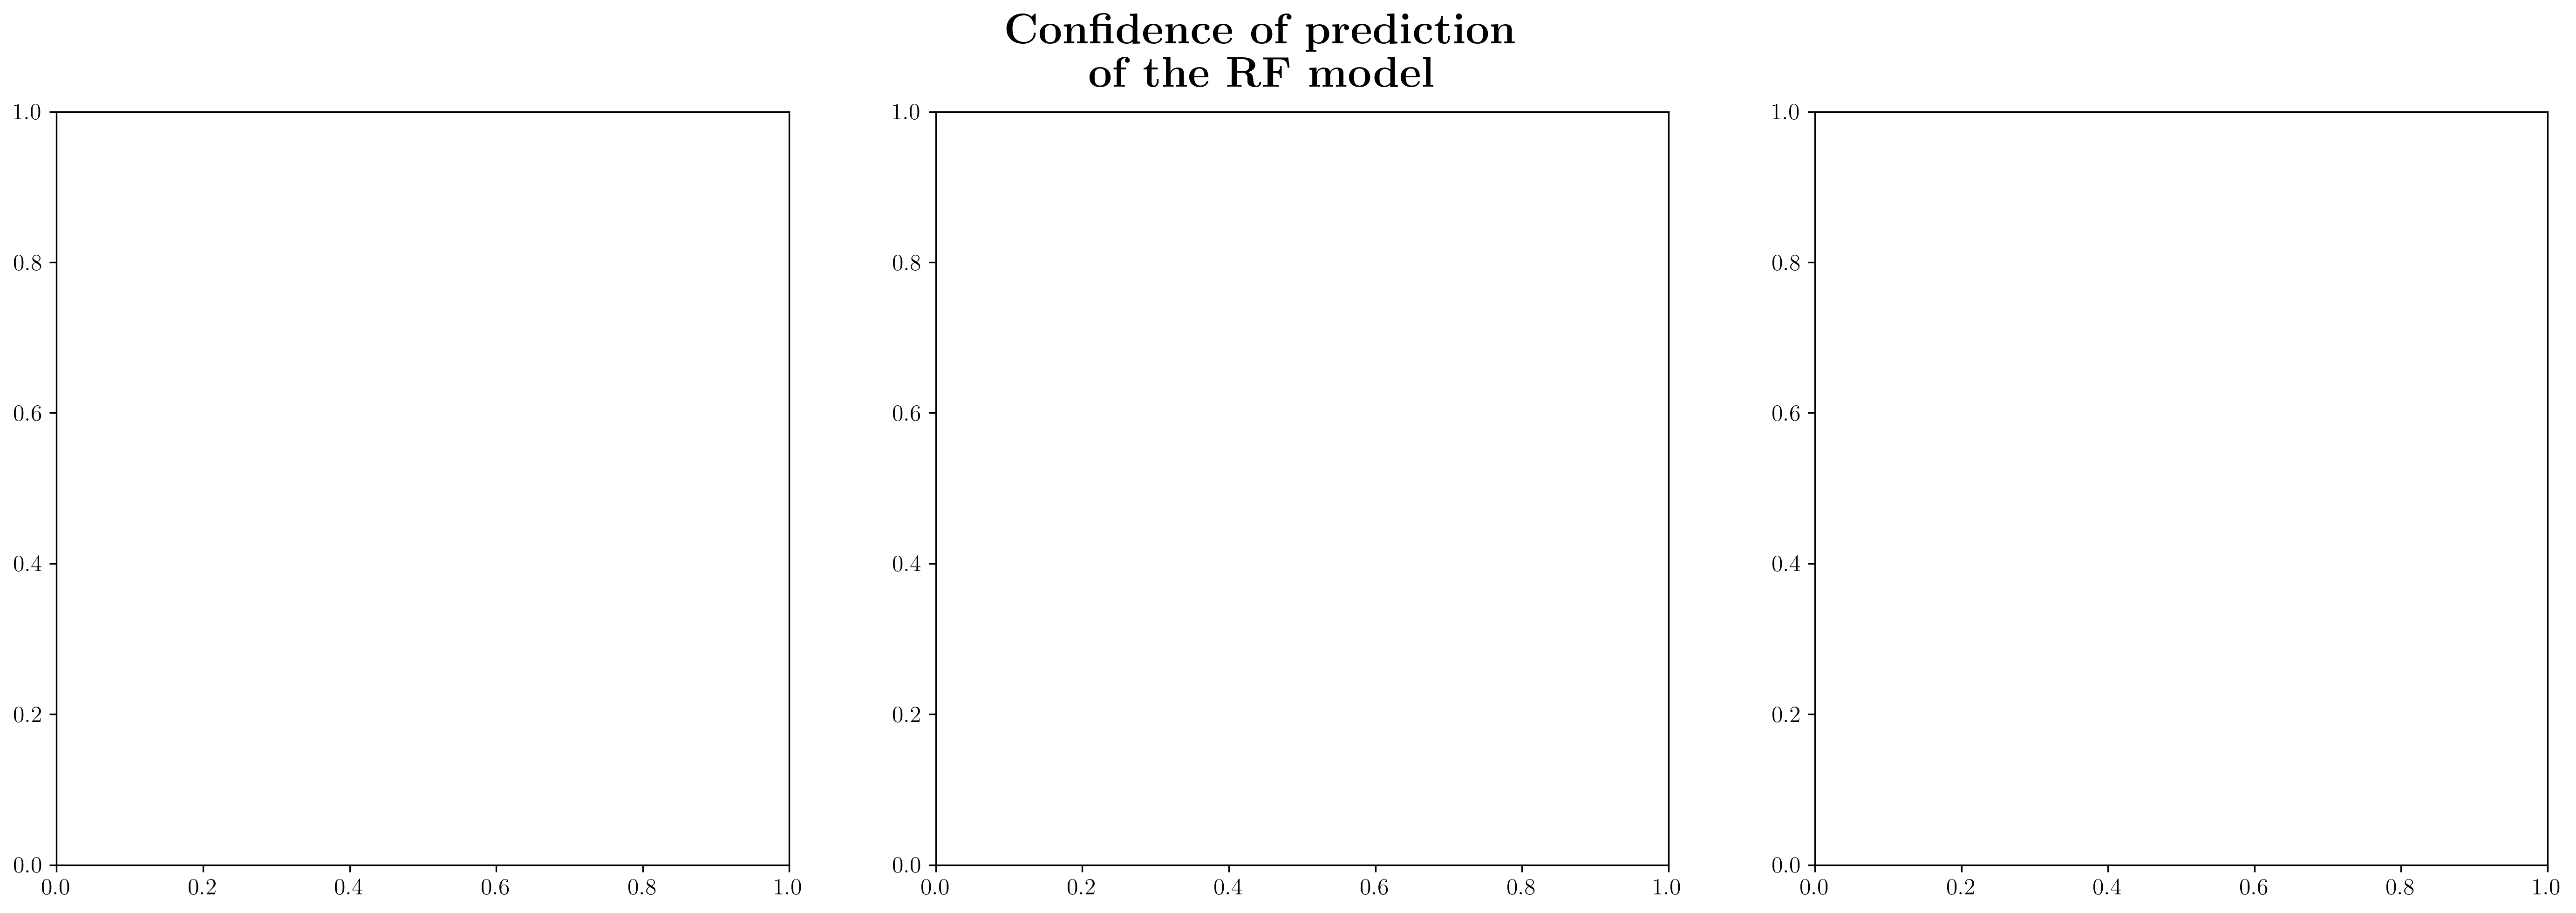

In [ ]:
handles, labels = [], []

# def plot_graphs_rf_confidence(pred_dfs: dict[str, pd.DataFrame], key: str, ax: Axes):
#     ax.set_title(f"{key}")
#     df = pred_dfs[key]
#     x, y = np.unique(df.values[:,0]), np.unique(df.values[:,1])
#     x, y = x.astype(float), y.astype(float)
#     conf = df["rf_confidence"].astype(float).values
#     conf_2d = conf.reshape(len(x), len(y))
#     X, Y = np.meshgrid(x,y)
#     ax.pcolormesh(
#         X,Y,conf_2d.T, shading='auto', vmin=0, vmax=1
#     )

_fig, _axs = plt.subplots(figsize=(23, 7), ncols=3, nrows=1, dpi=300)
_fig.suptitle(r"""$\textbf{Confidence of prediction}$
              $\textbf{of the RF model}$""")

# Store the mappable returned by pcolormesh for colorbar
mappables = []
for i in range(3):
    ax = _axs.flatten()[i]
    key = H_KEYS[i]
    df = pred_dfs[key]
    label = ""
    if i == 2:
        label = "Theoretical transitions"
        x, y = df.values[:, 0], df.values[:, 1]
        x, y = x.astype(float), y.astype(float)
        conf = df["lr_confidence"].astype(float).values
        ax.scatter(
            x,
            y,
            c=conf,
            cmap="viridis",
            alpha=0.8,
            s=14,
        )
    else:
        x, y = np.unique(df.values[:, 0]), np.unique(df.values[:, 1])
        conf = df["lr_confidence"].astype(float).values
        conf_2d = conf.reshape(len(x), len(y))
        X, Y = np.meshgrid(x, y)
        mappable = ax.pcolormesh(
            X, Y, conf_2d.T, shading="gouraud", cmap="viridis", vmin=0, vmax=1
        )
        mappables.append(mappable)
    ax.scatter(
        PHASE_TRANSITIONS[key][:, 0],
        PHASE_TRANSITIONS[key][:, 1],
        marker="o",
        edgecolor="black",
        label=label,
        color="white",
        alpha=1,
        s=30,
    )
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

    ax.set_title(f"{H_KEYS[i]}")


plt.tight_layout(rect=(0.0, 0.07, 1.0, 0.96))  # Adjust rect to make space for suptitle

# Add colorbar using the first mappable
_fig.colorbar(mappables[0], ax=_axs, label="Confidence")
_fig.legend(
    loc="lower right",
    fontsize=18,
    bbox_to_anchor=(0.88, -0.01),
)
_fig.savefig(f"images/lr_confidence_N{N}.png")

In [ ]:
df.to_numpy()

ValueError: could not broadcast input array from shape (6,6400) into shape (1,6400)